In [1]:
import os
import numpy as np
import numpy.random as npr
import matplotlib.pyplot as plt
import pandas as pd
from tqdm import tqdm
from scipy.integrate import odeint
from Utils.Models import *
from Utils.EABCSMC import *
from Utils.Preconditioning import * 

%config InlineBackend.figure_format = 'retina' 
%matplotlib inline

In [2]:

def SEIRD(z, t, S0, beta0, gamma, mu0):
    if t == 0:
        I, R, D, E = z
        E = 2.888 * beta0
    else:
        I, R, D, E = z
    S0 = 100000*S0
    S = S0 - I - R - D - E
    mu = mu0 * (1/(t+1))
    alpha = 0.83 * beta0
    beta = beta0 * np.exp(-0.0784* beta0 * t) 
    dS = - beta * I * S / S0
    dE = beta * I * S / S0 - alpha * E
    dI = alpha * E - gamma * I - mu * I
    dR = gamma * I
    dD = mu * I

    dzdt = [dI, dR, dD, dE]
    return dzdt

In [3]:
italy = pd.read_csv('Data/Sird_bigdata.csv')
italy.fillna(0, inplace = True)

Precond = Preconditioner(SEIRD, 'SEIRD')

Precond.preprocess_data(data=italy, start=0, eff=90, ext=150)
popt, pcov = Precond.fit(p0 = (5.45, 0.44, 0.020, 0.30), bounds=([0, 0, 0, 0], [20, 3, 3,  3]))

In [4]:
popt

array([5.47793226, 0.68890095, 0.0216269 , 0.31708015])

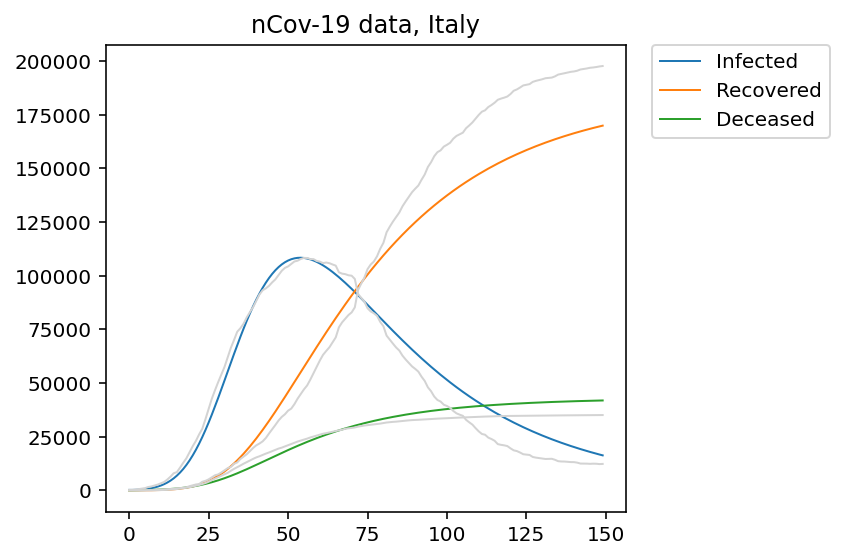

In [5]:
simul_yy =  odeint(SEIRD, (221,7,1,0), np.arange(150), args=tuple(np.reshape(popt,(1,-1))[0]))
plot_traj_SIRD(simul_yy)
plot_traj_gray_SIRD(Precond.extended_y)

In [6]:
extended_yy = np.append(Precond.extended_y[:,0],Precond.extended_y[:,1])
extended_yy = np.append(extended_yy,Precond.extended_y[:,2])

In [7]:
residuals = np.ravel(extended_yy) - Precond.fit_odeint(np.arange(150), *popt)
ss_res = np.sum(residuals**2)

ss_tot = np.sum((np.ravel(extended_yy)-np.ravel(np.mean(extended_yy)))**2)

r_squared = 1 - (ss_res / ss_tot)

r_squared 

0.9610991804769836

Text(0.5, 1.0, 'Correlation Matrix')

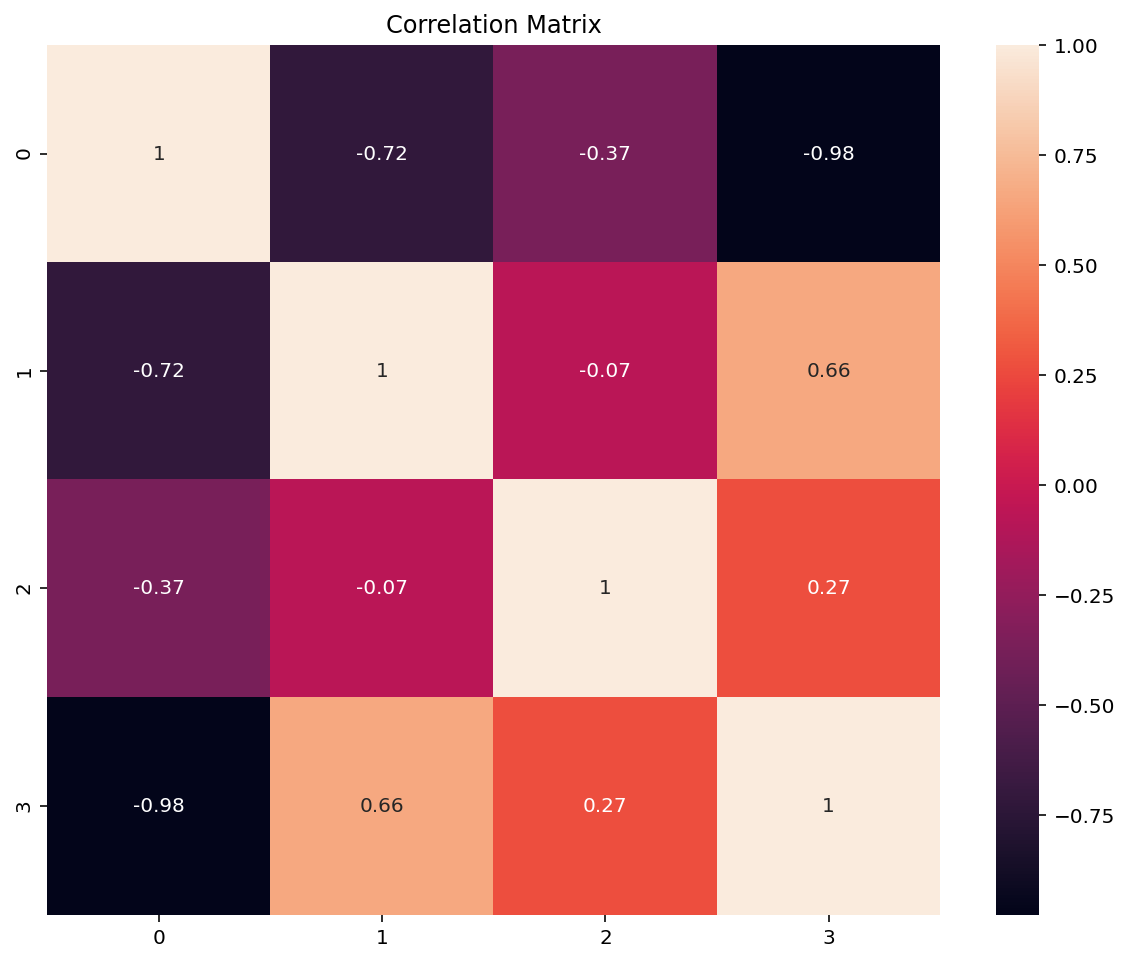

In [8]:
def compute_corr(covariance):
    v = np.sqrt(np.diag(covariance))
    outer_v = np.outer(v, v)
    correlation = covariance / outer_v
    correlation[covariance == 0] = 0
    return correlation

import seaborn as sns

corr = compute_corr(pcov)

plt.figure(figsize=(10,8))

sns.heatmap(corr, annot = True)

plt.title("Correlation Matrix")


In [9]:
lambda_ranges = [lambda : npr.uniform(low = 0.5, high = 5), lambda: npr.uniform(low = 0.5, high = 5), lambda: npr.uniform(low = 0.5, high = 5),
                lambda: npr.uniform(low = 0.5, high = 5)]
prior_means =  np.array([5, 0.388,  0.02922435,  0.30892933])

Sampler = EABCSMCSampler(true_y = Precond.true_yy, ODEmodel = Precond.fit_odeint, num_param = len(popt), numerical_estimate = popt, final_time = 90, 
                         prior_means = prior_means, lambda_ranges = lambda_ranges, n_jobs = 3)

In [10]:
lambda_ranges

[<function __main__.<lambda>()>,
 <function __main__.<lambda>()>,
 <function __main__.<lambda>()>,
 <function __main__.<lambda>()>]

  0%|                                                                                | 3/30000 [00:00<24:58, 20.02it/s]

Borders estimation start...


  0%|▏                                                                             | 30/15000 [00:00<00:53, 277.57it/s]

Acceptance rate:  0.0244
Borders estimation completed, starting preprocessing...
Borders: [1.6164327590351562, 0.44339299944914395, 0.009039125352390601, 0.000702443280044165]


  0%|▏                                                                             | 30/15000 [00:00<00:58, 257.64it/s]

Acceptance rate:  0.014133333333333333
Preprocessing completed, starting ABC-SMC


  0%|                                                                              | 18/15000 [00:00<01:30, 166.23it/s]

Acceptance rate:  0.047933333333333335
ABS-SMC round :  2


  0%|                                                                              | 18/90000 [00:00<09:24, 159.48it/s]

Acceptance rate:  0.023466666666666667
ABS-SMC round :  3


100%|███████████████████████████████████████████████████████████████████████████| 90000/90000 [08:56<00:00, 167.69it/s]


Acceptance rate:  0.011644444444444445


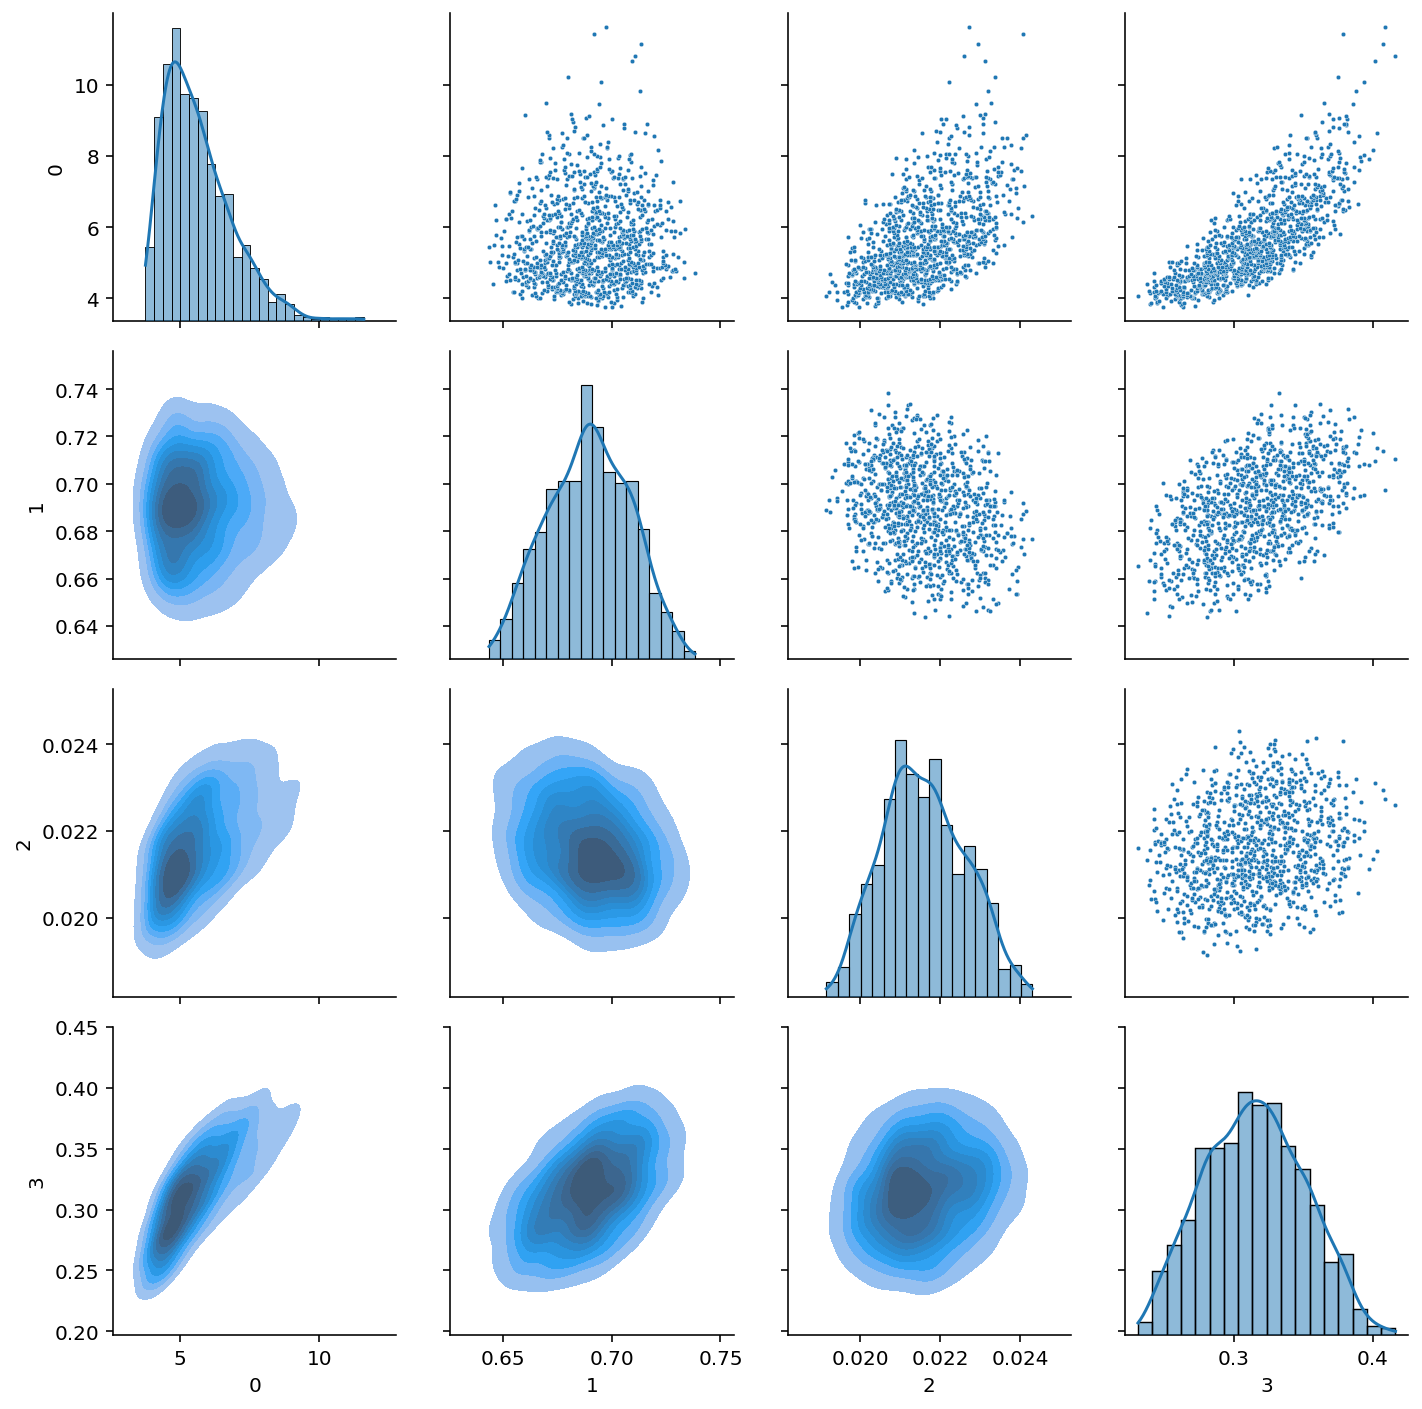

In [11]:
npr.seed(42)
Sampler.fit(niters=3000, eps_schedule=[2, 1, 1/2, 1/4, 1/8], niters_schedule=[10, 5, 5, 5, 30])
Sampler.pairplot()

In [3]:
parameters = Sampler.parameters

NameError: name 'Sampler' is not defined

In [12]:
params =parameters

NameError: name 'parameters' is not defined

In [14]:
np.save('parameters_seird_90.npy', parameters)

In [16]:
def plot_traj_SIRD(trajectories, width=1.):
    x2 = trajectories[:, 0]
    x3 = trajectories[:, 1]
    x4 = trajectories[:, 2]

    i = plt.plot(x2, linewidth=width, label='Infected', color = 'navy')
    r = plt.plot(x3, linewidth=width, label='Recovered', color = (.21,.39,.55))
    d = plt.plot(x4, linewidth=width, label='Deceased', color = (0.39,.72,1))

    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)
    # plt.title('Real SIRD')
    plt.title('SEIRD prediction at day 30')
    plt.tight_layout()
    
def plot_traj_SIRD2(trajectories, width=1.):
    x2 = trajectories[:, 0]
    x3 = trajectories[:, 1]
    x4 = trajectories[:, 2]
    color_ = (0,0,0.5)
    

    i = plt.plot(x2, linewidth=width/3,color = 'navy', linestyle = 'dashed' )
    r = plt.plot(x3, linewidth=width/3, color = (.21,.39,.55), linestyle = 'dashed')
    d = plt.plot(x4, linewidth=width/3,  color = (0.39,.72,1), linestyle = 'dashed')

    # plt.title('Real SIRD')
    plt.tight_layout()

100%|██████████████████████████████████████████████████████████████████████████████| 1048/1048 [00:12<00:00, 86.99it/s]


102813.44308472762 114260.51544132917
51.0 57.0
55
108257.0


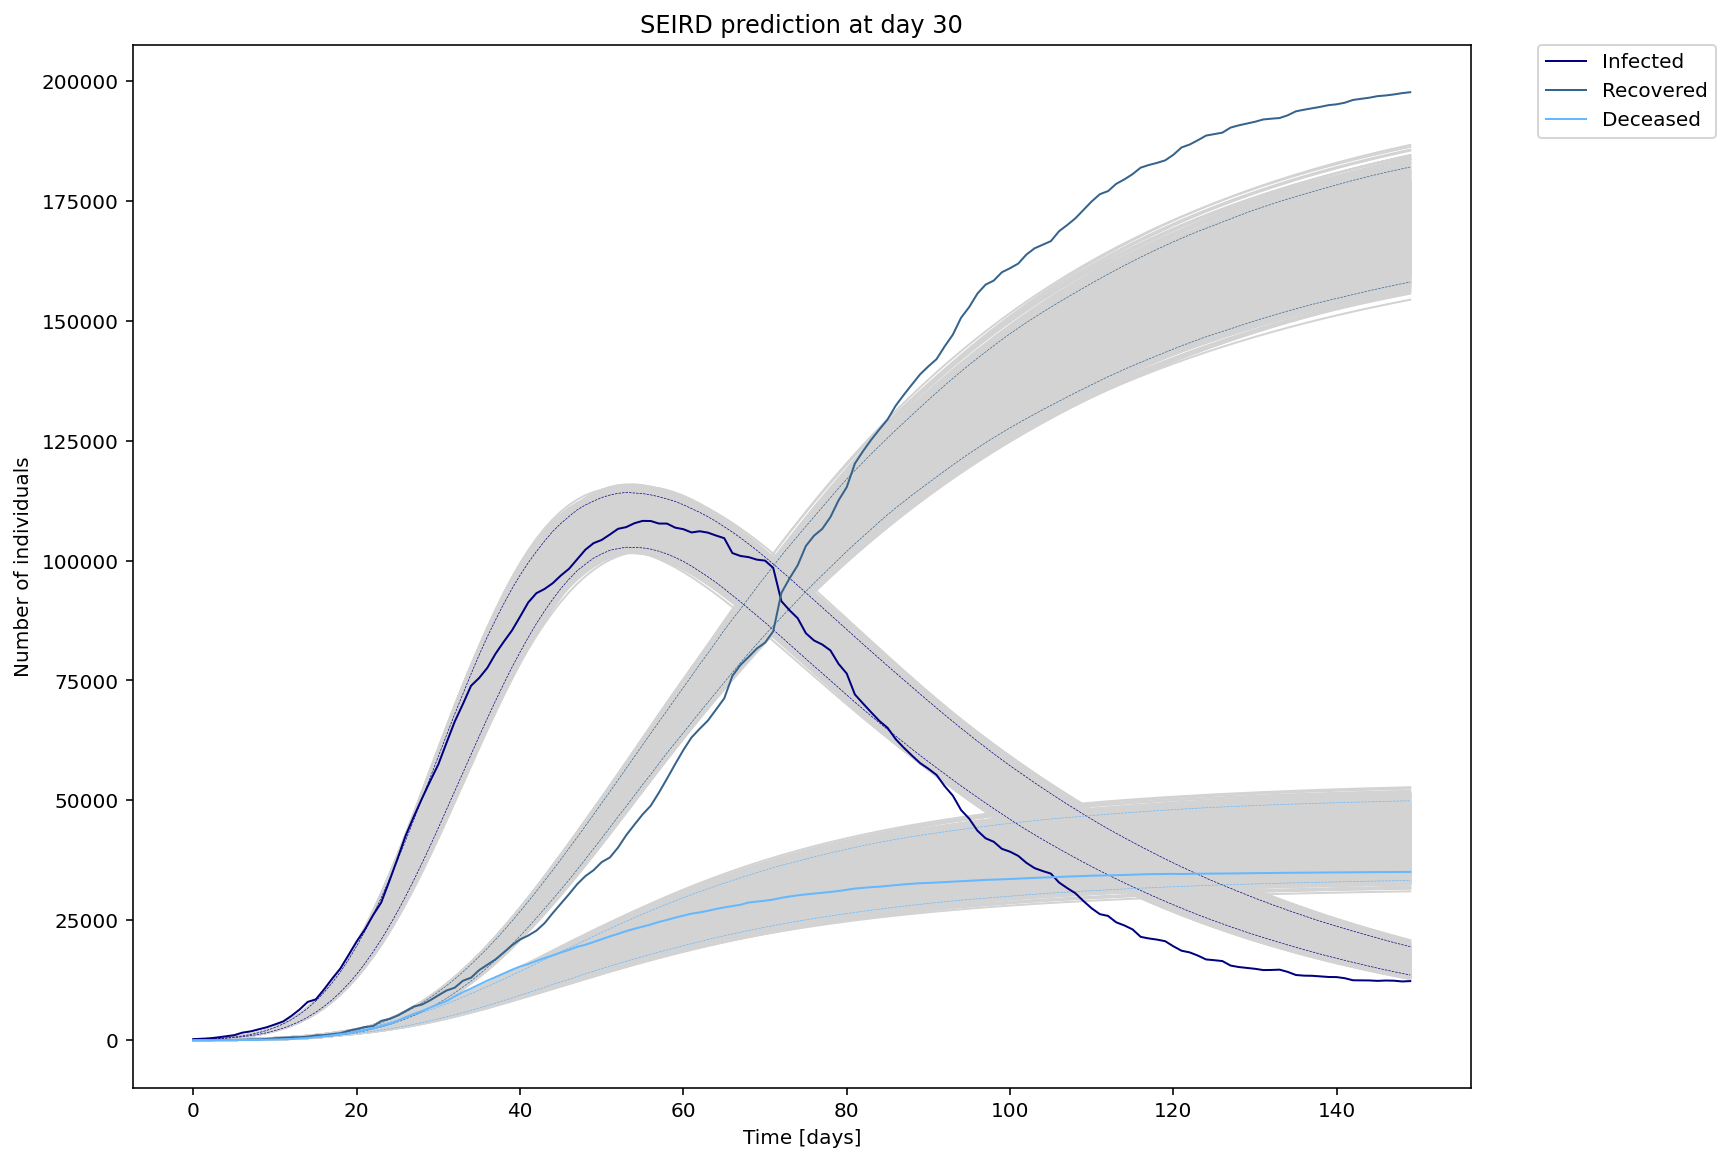

<Figure size 432x288 with 0 Axes>

In [17]:
# magari anche questo lo metto dentro all'abc sampler
# magari anche questo lo metto dentro all'abc sampler

fig = plt.figure(figsize = (12,8))

peak = []
day_peak = []
simul_all = []

for j in tqdm(range(parameters.shape[0])):
    simul_yy =  odeint(SEIRD, [221,1,7,0], np.arange(150), args=tuple(parameters[j]))
    simul_all.append(simul_yy)
    plot_traj_gray_SIRD(simul_yy)
    peak.append(max(simul_yy[:,0]))
    day_peak.append(np.argmax(simul_yy[:,0]))

simul_all = np.array(simul_all)
q95 = []
q05 = []
mean = []
sd = []
for i in range(150):
    q95.append([np.quantile(simul_all[:,i,0],0.975),np.quantile(simul_all[:,i,1],0.975),np.quantile(simul_all[:,i,2],0.975)])
    q05.append([np.quantile(simul_all[:,i,0],0.025),np.quantile(simul_all[:,i,1],0.025),np.quantile(simul_all[:,i,2],0.025)])
    mean.append([np.mean(simul_all[:,i,0]),np.mean(simul_all[:,i,1]),np.mean(simul_all[:,i,2])])
    sd.append([np.std(simul_all[:,i,0]),np.std(simul_all[:,i,1]),np.std(simul_all[:,i,2])])

q95 = np.array(q95)    
q05 = np.array(q05)  

plot_traj_SIRD2(q95)

plot_traj_SIRD2(q05)

plot_traj_SIRD(Precond.extended_y)

print(np.quantile(peak,0.025), np.quantile(peak,0.975))
print(np.quantile(day_peak,0.025), np.quantile(day_peak,0.975))
print(np.argmax(Precond.extended_y[:,0]))
print(np.max(Precond.extended_y[:,0]))

plt.ylabel('Number of individuals')
plt.xlabel('Time [days]')
plt.show()
plt.savefig('Seird_30days.png')

In [ ]:
PBR = 0
for i in range(31,150):
    PBR += np.sum([(Precond.extended_y[i][j] - mean[i][j] / sd[i][j])**2 for j in range(2)])

In [ ]:
PBR

In [ ]:
PBR / 2825480187584.038

In [ ]:
parameters[:,3]

In [ ]:
t = np.arange(150)

fig = plt.figure(figsize = (10,7))

day_max = []

for j in range(parameters.shape[0]):
    plt.plot(t, parameters[j,1]* np.exp(-(0.0952 * parameters[j,1]) * t)/((parameters[j,3]/(t+1)) + parameters[j,2]), linewidth = 1, color = 'lightgray')
    day_max.append(np.argmax(parameters[j,1]* np.exp(-(0.0952 * parameters[j,1]) * t)/((parameters[j,3]/(t+1)) + parameters[j,2])))
    
plt.title('Rt predicted by SEIRD model')
plt.ylabel('Predicted Rt')
plt.xlabel('Time [days]')
print(min(day_max), max(day_max))  

In [ ]:
np.quantile(params[:,1],0.025) , np.quantile(params[:,1],0.975) 